In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
import random
import seaborn as sns
import skbio.diversity.alpha as alpha
import math


/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Importing OTU table, normalization (change to relative abundances), set training and testing groups

In [2]:
# Import data into a pandas dataframe
otu_table = pd.read_csv('EGAD00001003453.otu_table.99.denovo', sep='\t', header=0, index_col=0)

#Transpose OTU table so that samples are rows and OTUs are columns
otu_table = otu_table.T

#Convert to relative abundances
#Normalize each person to 1 (change to relative abundances)
otu_table_normalized = otu_table.div(otu_table.sum(axis=1), axis=0)

In [3]:
#Make training and testing sets (50/50 for now)

#Scramble existing table with hard-coded random seed
otu_table_normalized = otu_table_normalized.sample(frac=1, random_state=1)

#Make first half training and second half testing
total_people = otu_table_normalized.shape[0]
print(total_people)
midway = total_people/2
training_table = otu_table_normalized.iloc[0:int(midway)]
testing_table = otu_table_normalized.iloc[int(midway):]


1010


### Set conditions to test:

In [4]:
N = [5, 10, 25, 40, 50, 60, 75, 100, 200]
weight_setup = ['even', 'uneven_100x', 'uneven_10x', 'uneven_graduated']#, 'uneven_bins']
num_bins = 3

#Number of times to run each condition (N and weight setup)
num_repeats = 30

### Functions

Returns list of weights to multiply by relative abundance matrix according to parameters n and weight

In [5]:
def calculate_weights(n,weight):
    if weight == 'even':
        return [1/n]*n
    elif weight == 'uneven_100x':
        x = 1/(100 + (n-1))
        return [100*x] + [x]*(n-1)
    elif weight == 'uneven_10x':
        x = 1/(10 + (n-1))
        return [10*x] + [x]*(n-1)
    elif weight == 'uneven_graduated':
        decreasing_list = list(range(n,0,-1))
        return [x/sum(decreasing_list) for x in decreasing_list]    

### Master loop: Generate all samples for given conditions

In [6]:
df_list = []
#Generate matrix of random seeds of size num_repeats x len(N), which is how many random numbers are needed for this sampling experiment
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = training_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as new pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
final_matrix = pd.concat(df_list, axis=1)
print(final_matrix.tail())

                                       0  \
OTU_ID                                     
sample_name                     5_even_0   
N                                      5   
weight_setup                        even   
weight_vector  [0.2, 0.2, 0.2, 0.2, 0.2]   
random_seed                         6138   

                                                               1  \
OTU_ID                                                             
sample_name                                      5_uneven_100x_0   
N                                                              5   
weight_setup                                         uneven_100x   
weight_vector  [0.9615384615384616, 0.009615384615384616, 0.0...   
random_seed                                                 6138   

                                                               2  \
OTU_ID                                                             
sample_name                                       5_uneven_10x_0   
N         

In [7]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
final_matrix = final_matrix.T

In [8]:
#Save final_matrix to a csv file
final_matrix.to_csv('final_matrix.csv')

In [9]:
#otu_table_normalized.max().sort_values(ascending=False)

In [10]:
#final_matrix.iloc[:, :-5].max().sort_values(ascending=False)

In [11]:
final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,denovo22219,denovo22218,denovo43272,denovo32739,denovo32738,sample_name,N,weight_setup,weight_vector,random_seed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",6138
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",6138
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",6138
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",6138
4,4.13959e-07,0,0,0,2.75972e-07,0,0,0,0,0,...,1.36838e-07,0,0,0,0,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",26669
5,3.79779e-09,0,0,0,2.53186e-09,0,0,0,0,0,...,1.2554e-09,0,0,0,0,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",26669
6,1.99883e-10,0,0,0,1.33256e-10,0,0,0,0,0,...,6.60735e-11,0,0,0,0,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",26669
7,1.09027e-11,0,0,0,7.26849e-12,0,0,0,0,0,...,6.00668e-12,0,0,0,0,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",26669
8,6.65087e-08,7.18755e-08,0,0,0,0,0,0,0,3.80898e-08,...,4.38891e-08,2.21696e-08,0,0,2.19446e-08,25_even_0,25,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",23098
9,5.36361e-10,5.79641e-10,0,0,0,0,0,0,0,3.07176e-10,...,3.53945e-10,1.78787e-10,0,0,1.76972e-10,25_uneven_100x_0,25,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",23098


### Look at various metrics from samples

#### Number of OTUs detected per sample

In [12]:
final_matrix['n_otus'] = final_matrix[:final_matrix.shape[0]-5].astype(bool).sum(axis=1).astype(int)

In [13]:
final_matrix_rel = final_matrix.iloc[:,:-6]
final_matrix_otus_only = final_matrix.iloc[:,:-6]*10000000
final_matrix_otus_only = final_matrix_otus_only.astype(int)

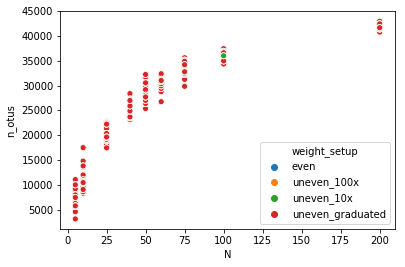

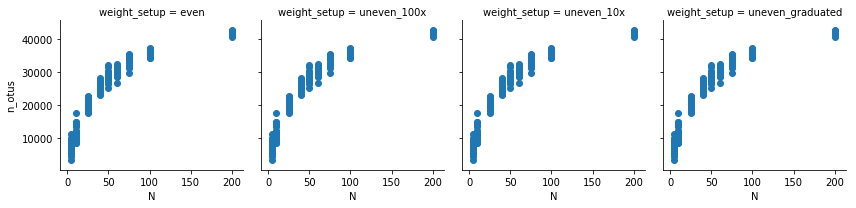

In [14]:
sns.scatterplot(x='N',y='n_otus',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'n_otus')
plt.show()

#### Alpha diversity: chao1

In [15]:
final_matrix['chao1'] = [alpha.chao1(list(row),bias_corrected=True) for index, row in final_matrix_otus_only.iterrows()]

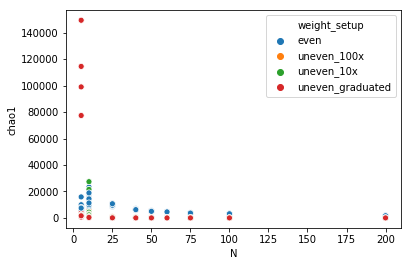

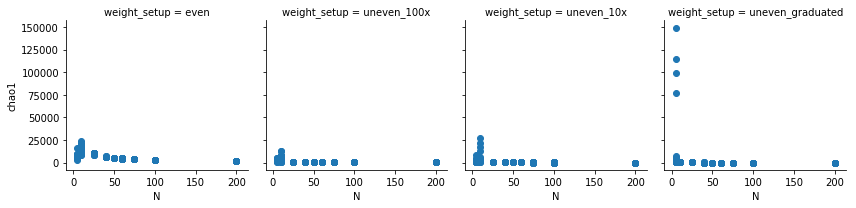

In [16]:
sns.scatterplot(x='N',y='chao1',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'chao1')
plt.show()

#### Alpha diversity: fisher_alpha

In [17]:
final_matrix['fisheralpha'] = [alpha.fisher_alpha(list(row)) for index, row in final_matrix_otus_only.iterrows()]

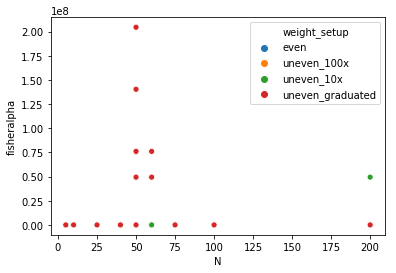

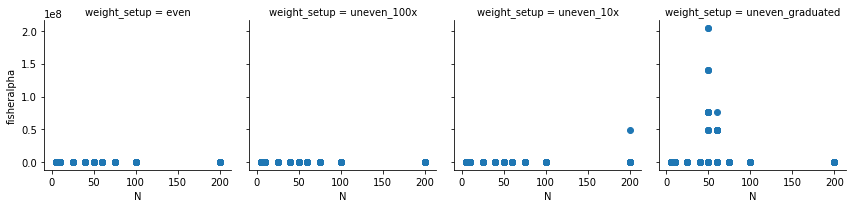

In [18]:
sns.scatterplot(x='N',y='fisheralpha',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'fisheralpha')
plt.show()

#### Alpha diversity: shannon

Approach 1: Add 1 to every value in count matrix (converted from rel abundance matrix) and use skbio function

In [19]:
final_matrix['shannon_pseudocount'] = [alpha.shannon(list(row + 1),base=2) for index, row in final_matrix_otus_only.iterrows()]

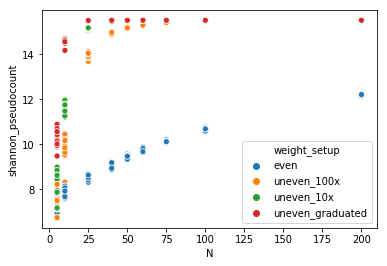

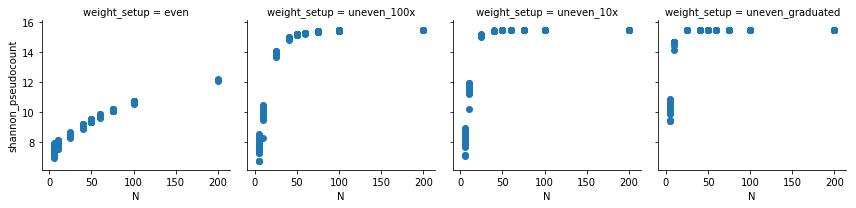

In [20]:
sns.scatterplot(x='N',y='shannon_pseudocount',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'shannon_pseudocount')
plt.show()

Approach 2: Add minimum value in relative abundance matrix to each value in matrix, calculate shannon using skbio function

In [22]:
#final_matrix['shannon'] = [alpha.shannon(list(row),base=2) for index, row in final_matrix_otus_only.iterrows()]

min_value = final_matrix_rel[final_matrix_rel > 0].min().min()
print(min_value)
final_matrix_rel_add = final_matrix_rel + min_value
final_matrix['shannon'] = [alpha.shannon(list(row),base=2) for index, row in final_matrix_rel_add.iterrows()]


8.791354831025034e-20


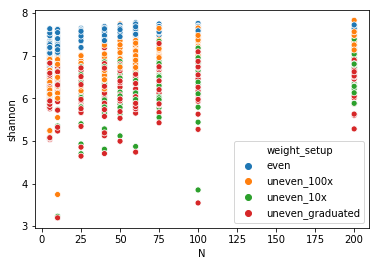

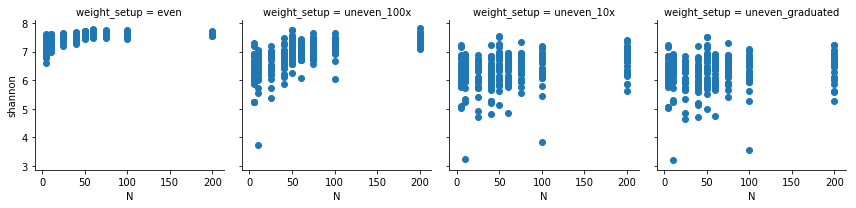

In [23]:
sns.scatterplot(x='N',y='shannon',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'shannon')
plt.show()

Approach 3: Add minimum value in relative abundance matrix to each value in matrix, calculate shannon by hand

In [25]:
final_matrix_shannon = final_matrix_rel_add.applymap(lambda x: x*math.log2(x))

In [26]:
final_matrix['shannon_by_hand'] = [-row.sum() for index, row in final_matrix_shannon.iterrows()]

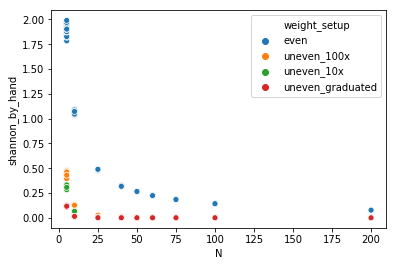

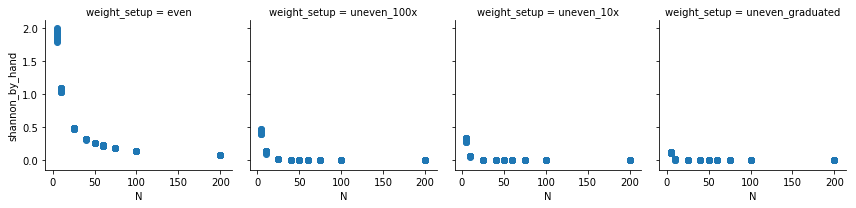

In [27]:
sns.scatterplot(x='N',y='shannon_by_hand',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'shannon_by_hand')
plt.show()

Approach 4: Take rel abundance matrix without adding minimum value, calculate shannon by hand

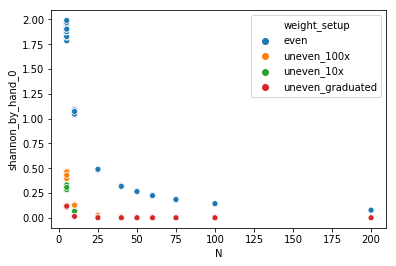

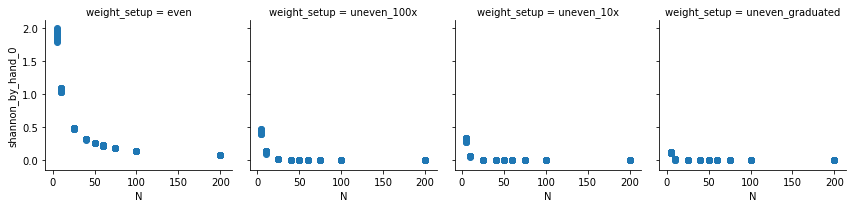

In [30]:
final_matrix_shannon = final_matrix_rel.applymap(lambda x: x*math.log2(x) if x!=0 else 0)
final_matrix['shannon_by_hand_0'] = [-row.sum() for index, row in final_matrix_shannon.iterrows()]

sns.scatterplot(x='N',y='shannon_by_hand_0',hue='weight_setup',data=final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'shannon_by_hand_0')
plt.show()

In [29]:
final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,weight_setup,weight_vector,random_seed,n_otus,chao1,fisheralpha,shannon_pseudocount,shannon,shannon_by_hand,shannon_by_hand_0
0,0,0,0,0,0,0,0,0,0,0,...,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",6138,4540.0,4535.000000,5.536343e+02,7.225871,6.895463,1.843478e+00,1.843478e+00
1,0,0,0,0,0,0,0,0,0,0,...,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",6138,4540.0,1663.000000,2.076455e+02,7.845134,6.463269,4.442850e-01,4.442850e-01
2,0,0,0,0,0,0,0,0,0,0,...,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",6138,4540.0,1470.000000,1.997754e+02,8.275983,6.402491,3.194760e-01,3.194760e-01
3,0,0,0,0,0,0,0,0,0,0,...,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",6138,4540.0,1425.004144,2.397211e+02,10.337204,6.398249,1.208107e-01,1.208107e-01
4,4.13959e-07,0,0,0,2.75972e-07,0,0,0,0,0,...,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",26669,9483.0,10246.696756,1.258706e+03,7.843425,7.299936,1.062186e+00,1.062186e+00
5,3.79779e-09,0,0,0,2.53186e-09,0,0,0,0,0,...,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",26669,9483.0,1278.200000,1.911617e+02,10.083323,6.358355,1.300221e-01,1.300221e-01
6,1.99883e-10,0,0,0,1.33256e-10,0,0,0,0,0,...,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",26669,9483.0,17362.166667,1.884445e+02,11.661414,6.144037,6.735742e-02,6.735742e-02
7,1.09027e-11,0,0,0,7.26849e-12,0,0,0,0,0,...,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",26669,9483.0,380.357143,6.398889e+01,14.609862,6.129317,1.435380e-02,1.435380e-02
8,6.65087e-08,7.18755e-08,0,0,0,0,0,0,0,3.80898e-08,...,even,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...",23098,19428.0,10403.400628,1.051039e+03,8.583231,7.528045,4.868760e-01,4.868760e-01
9,5.36361e-10,5.79641e-10,0,0,0,0,0,0,0,3.07176e-10,...,uneven_100x,"[0.8064516129032258, 0.008064516129032258, 0.0...",23098,19428.0,898.000000,1.098718e+02,14.036500,6.904016,2.590676e-02,2.590676e-02
